In [208]:
require("Rsamtools")
require("Hmisc")
require("dplyr")
require("ggplot2")
require("stringi")
require("stats")
require("Biostrings")
require("reshape2")
require("viridis")
require("seqinr")
require("stringr")

In [209]:
DB="EquAllRS"
fxG="/hpc/compgen/projects/cf-spi/cf-spi/analysis/ewesdorp/ssdna-snakemake-analysis/foals_sepsis_EquCabAll_post_cfSPI/fragmentomics/"
db_dir="/hpc/compgen/projects/cf-spi/cf-spi/analysis/ewesdorp/make_database/"

In [210]:
file_list <- list.files(path = fxG, pattern = "R1.fastq")
if (exists("all_G")){rm("all_G")}
for (f in file_list[grepl(file_list, pattern = "PC")]){
    if(grepl(f, pattern = paste0("_", DB,"_"))){
        fastq_tmp <- read.table(file = paste0(fxG, f), sep = "\n") 

        fastq_end_df <- data.frame(seq = fastq_tmp[seq(2, nrow(fastq_tmp), 4),]) %>% 
                    mutate(dn = substring(text = seq, 0, 2))  %>% 
                    group_by(dn) %>% 
                    summarise(count = n())

        fastq_tl <- dinucleotideFrequency(x = DNAStringSet(fastq_tmp[seq(2, nrow(fastq_tmp), 4),]), 
            step=1, as.prob=FALSE, as.matrix=FALSE, fast.moving.side="right", with.labels=TRUE) %>% 
            colSums() 
        
        fastq_tl_df <- data.frame(dn = names(fastq_tl), count_tile = fastq_tl)

        fastq_all_df <- merge(fastq_end_df, fastq_tl_df, by = "dn", all = TRUE) %>% 
                mutate(sample_id = unlist(strsplit(f, split = "_"))[1]) %>%  
                mutate(taxId = unlist(strsplit(f, split = "_"))[4])

        if (!exists("all_G")){all_G <- fastq_all_df} else {all_G <- rbind(all_G, fastq_all_df)}
        rm("fastq_tmp"); rm("fastq_end_df"); rm("fastq_tl");rm("fastq_tl_df");rm("fastq_all_df")
    }
} 

insp_file <- read.csv(file = paste0(db_dir, DB, "_inspect.txt"), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
insp_file$V6 <-  str_trim(insp_file$V6, side = "left")
all_G$taxNm <- NA
for (txd in unique(all_G$taxId)){
    txd_names <- insp_file$V6[insp_file$V5 == txd] 
    all_G <- all_G %>% mutate(taxNm = ifelse(taxId == txd, yes = txd_names, no = taxNm)) 
}

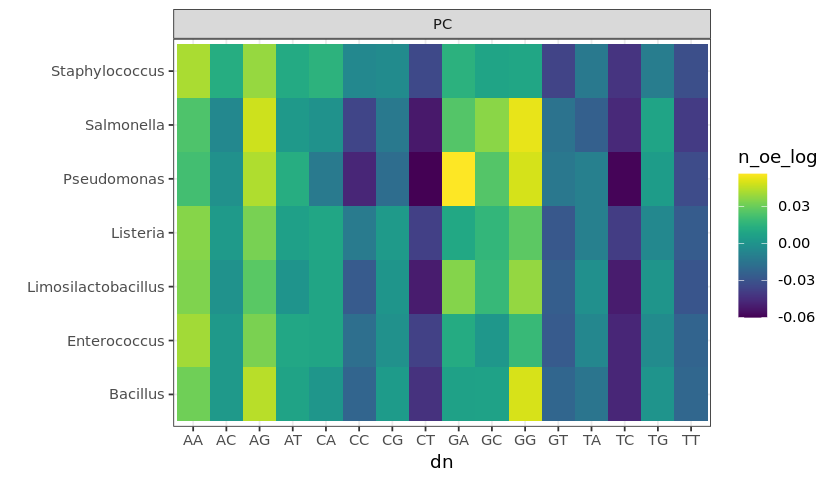

In [216]:
options(repr.plot.width=7, repr.plot.height=4)
all_G %>% #head()
    filter(taxNm %in% c("Pseudomonas", "Salmonella", "Limosilactobacillus", #"Escherichia"
                        "Enterococcus", "Staphylococcus", "Listeria", "Bacillus")) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    group_by(taxNm, sample, sample_id) %>% 
    mutate(ncount = count/sum(count)) %>%
    mutate(ncount_tile = count_tile/sum(count_tile)) %>% 
    mutate(n_oe_log = log10(ncount/ncount_tile), n_oe = ncount/ncount_tile) %>%
    ggplot(aes(x = dn, y = taxNm, fill = n_oe_log)) + 
        geom_tile() + scale_fill_viridis() + 
        facet_grid(cols = vars(sample), scales = "free", space = "free") + 
        theme_bw() + ylab("") 

`summarise()` has grouped output by 'taxNm'. You can override using the `.groups` argument.


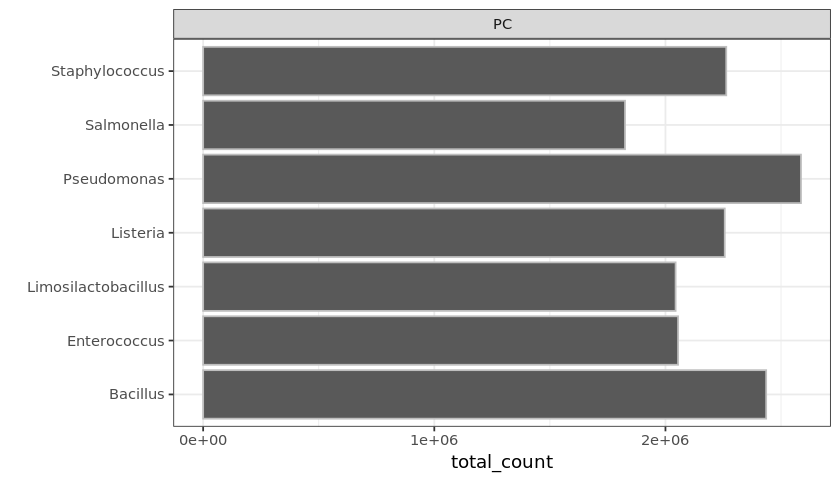

In [215]:
options(repr.plot.width=7, repr.plot.height=4)
all_G %>% 
    filter(taxNm %in% c("Pseudomonas", "Salmonella", "Limosilactobacillus", #"Escherichia"
                        "Enterococcus", "Staphylococcus", "Listeria", "Bacillus")) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "^P"), yes = "PC", no = 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "NC", no = "sample"))) %>% 
    filter(!grepl(dn, pattern = "N")) %>% 
    group_by(taxNm, sample) %>% #head()
    summarise(total_count = sum(count)) %>% #head()
    ggplot(aes(x = total_count, y = taxNm)) + 
        geom_bar(position = "dodge", stat = "identity", col = "grey") + 
        facet_grid(cols = vars(sample), scales = "free_y", space = "free") + 
        #scale_x_continuous(trans='log10') + xlab("log10(count)") +
        theme_bw() + ylab("")